In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

# celý DF/GeoDF vypisovat bez limitu
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Load OD matrix
df = pd.read_excel('../../data/czech/data_czech.xlsx')

# Rename column for clarity and reshape to long format
df = df.rename(columns={'University ↓ / Student →': 'origin'}).melt(id_vars='origin', var_name='destination', value_name='value')

# Clean up leading/trailing spaces
df['origin'] = df['origin'].str.strip()
df['destination'] = df['destination'].str.strip()

# Display tail
df.head()

,origin,destination,value
0,Hlavní město Praha,Hlavní město Praha,29879
1,Jihomoravský kraj,Hlavní město Praha,986
2,Jihočeský kraj,Hlavní město Praha,572
3,Královéhradecký kraj,Hlavní město Praha,366
4,Liberecký kraj,Hlavní město Praha,324


In [3]:
# Load spatial regions
gdf = gpd.read_file('../../data/czech/regions.gpkg')

# Keep only necessary columns and compute centroids
gdf = gdf[['nazev', 'geometry']]

# Compute centroids
gdf['centroid'] = gdf.representative_point()

# Show the result
gdf.head()

,nazev,geometry,centroid
0,Hlavní město Praha,"MULTIPOLYGON (((4644153.668 3017220.732, 46441...",POINT (4639467.91 3003862.303)
1,Jihočeský kraj,"MULTIPOLYGON (((4614559.886 2946839.972, 46145...",POINT (4654601.927 2896211.668)
2,Plzeňský kraj,"MULTIPOLYGON (((4557165.672 3003874.933, 45571...",POINT (4550638.407 2940237.936)
3,Karlovarský kraj,"MULTIPOLYGON (((4521107.248 3042368.86, 452110...",POINT (4521473.796 3010694.452)
4,Liberecký kraj,"MULTIPOLYGON (((4672911.633 3113397.259, 46729...",POINT (4673165.965 3082051.107)


In [4]:
# Merge centroids for origin and destination
df = df.merge(gdf[['nazev', 'centroid']], left_on='origin', right_on='nazev', how='left').rename(columns={'centroid': 'centroid_origin'}).drop(columns='nazev')
df = df.merge(gdf[['nazev', 'centroid']], left_on='destination', right_on='nazev', how='left').rename(columns={'centroid': 'centroid_destination'}).drop(columns='nazev')

# Filter valid rows (positive flow values and non-null centroids)
df = df[(df['value'] > 0) & df['centroid_origin'].notnull() & df['centroid_destination'].notnull()]

# Create flow lines based on centroids
df['geometry'] = df.apply(lambda row: LineString([row['centroid_origin'], row['centroid_destination']]), axis=1)

# Convert to GeoDataFrame
gdf_flows = gpd.GeoDataFrame(df, geometry='geometry', crs=gdf.crs)

# Weight the flow lines based on value
gdf_flows['weight'] = gdf_flows['value'] / gdf_flows['value'].max() * 10

# Show the result
gdf_flows

,origin,destination,value,centroid_origin,centroid_destination,geometry,weight
0,Hlavní město Praha,Hlavní město Praha,29879,POINT (4639467.91 3003862.303),POINT (4639467.91 3003862.303),"LINESTRING (4639467.91 3003862.303, 4639467.91...",10.000000
1,Jihomoravský kraj,Hlavní město Praha,986,POINT (4808459.225 2913016.631),POINT (4639467.91 3003862.303),"LINESTRING (4808459.225 2913016.631, 4639467.9...",0.329998
2,Jihočeský kraj,Hlavní město Praha,572,POINT (4654601.927 2896211.668),POINT (4639467.91 3003862.303),"LINESTRING (4654601.927 2896211.668, 4639467.9...",0.191439
3,Královéhradecký kraj,Hlavní město Praha,366,POINT (4726242.141 3049833.568),POINT (4639467.91 3003862.303),"LINESTRING (4726242.141 3049833.568, 4639467.9...",0.122494
4,Liberecký kraj,Hlavní město Praha,324,POINT (4673165.965 3082051.107),POINT (4639467.91 3003862.303),"LINESTRING (4673165.965 3082051.107, 4639467.9...",0.108437
5,Moravskoslezský kraj,Hlavní město Praha,232,POINT (4885595.656 3003867.756),POINT (4639467.91 3003862.303),"LINESTRING (4885595.656 3003867.756, 4639467.9...",0.077647
6,Olomoucký kraj,Hlavní město Praha,640,POINT (4821430.019 2996129.084),POINT (4639467.91 3003862.303),"LINESTRING (4821430.019 2996129.084, 4639467.9...",0.214197
7,Pardubický kraj,Hlavní město Praha,262,POINT (4761771.754 2996765.661),POINT (4639467.91 3003862.303),"LINESTRING (4761771.754 2996765.661, 4639467.9...",0.087687
8,Plzeňský kraj,Hlavní město Praha,657,POINT (4550638.407 2940237.936),POINT (4639467.91 3003862.303),"LINESTRING (4550638.407 2940237.936, 4639467.9...",0.219887
9,Středočeský kraj,Hlavní město Praha,548,POINT (4595294.569 3003861.945),POINT (4639467.91 3003862.303),"LINESTRING (4595294.569 3003861.945, 4639467.9...",0.183406


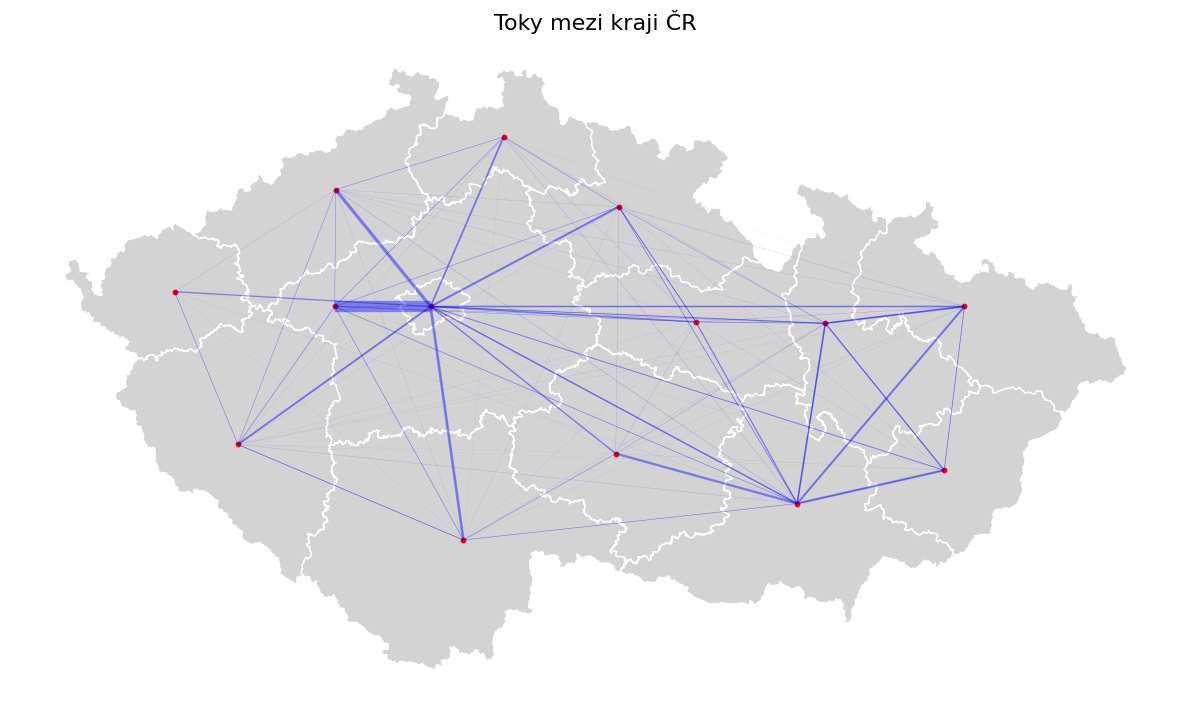

In [5]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot regions, flows, and centroids
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf_flows.plot(ax=ax, linewidth=gdf_flows['weight'], color='blue', alpha=0.4)
gdf.set_geometry('centroid').plot(ax=ax, color='red', markersize=10)

# Set plot title and remove axis
ax.set_title("Toky mezi kraji ČR", fontsize=16)
ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()